In [1]:
# Some basic thoughts and ideas jumbled together in CyberBattleSim and Networkx. 
# Added Human Node and Residential Nodes with BadUSB attacks and VPN Tunneling from Home-> Office env as base


In [1]:

from cyberbattle.simulation import model as m
import numpy as np
from typing import List, Optional, Tuple, DefaultDict
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from cyberbattle.simulation.model import Identifiers, NodeID, CredentialID, PortName, FirewallConfiguration, FirewallRule, RulePermission
import random

# Adjust Matplotlib Figsize
plt.rcParams['figure.figsize'] = [60, 60]

In [2]:
ENV_IDENTIFIERS = Identifiers(
    properties=[
        'breach_node'
    ],
  
    ports=['SMB', 'HTTP', 'RDP', 'VPN'],
    
    local_vulnerabilities=[
        'ScanWindowsCredentialManagerForRDP',
        'ScanWindowsExplorerRecentFiles',
        'ScanWindowsCredentialManagerForSMB'
    ],
    
    remote_vulnerabilities=[
        'Traceroute',
        'ConnectToMachineViaVPN'
    ],
    
    # Need to add this into model.py
    # physical_vulnerabilities: List[VulnerabilityID] = []
    
    physical_vulnerabilities =[
        'BadUSB'
    ]
)

In [3]:
ENV_IDENTIFIERS

Identifiers(properties=['breach_node'], ports=['SMB', 'HTTP', 'RDP', 'VPN'], local_vulnerabilities=['ScanWindowsCredentialManagerForRDP', 'ScanWindowsExplorerRecentFiles', 'ScanWindowsCredentialManagerForSMB'], remote_vulnerabilities=['Traceroute', 'ConnectToMachineViaVPN'], physical_vulnerabilities=['BadUSB'])

In [4]:
def generate_random_traffic_network(
    
    
    n_clients: int = 20,
    
    n_servers={
        "SMB":  1,
        "HTTP": 1,
        "RDP":  1,
        "VPN":  1
    },
    
    seed:      Optional[int] = 0,
    
    tolerance: np.float32    = np.float32(4e-3),
    
    alpha = np.array([
                    (0.1, 0.3), 
                    (0.18, 0.09)], 
                     dtype = float),
    
    beta = np.array([
                     (100, 10), 
                     (10, 100)], 
                      dtype = float),
    
) -> nx.DiGraph:
    
    """
    Randomly generate a directed multi-edge network graph representing
    fictitious SMB, HTTP, and RDP traffic.
    Arguments:
        n_clients: number of workstation nodes that can initiate sessions with server nodes
        n_servers: dictionary indicatin the numbers of each nodes listening to each protocol
        seed: seed for the psuedo-random number generator
        tolerance: absolute tolerance for bounding the edge probabilities in [tolerance, 1-tolerance]
        alpha: beta distribution parameters alpha such that E(edge prob) = alpha / beta
        beta: beta distribution parameters beta such that E(edge prob) = alpha / beta
    Returns:
        (nx.classes.multidigraph.MultiDiGraph): the randomly generated network from the hierarchical block model
    """
    edges_labels = defaultdict(set)  # set backed multidict
    

    
    for protocol in list(n_servers.keys()):
        
        sizes = [n_clients, n_servers[protocol]]
        
        # sample edge probabilities from a beta distribution
        np.random.seed(seed)
        
        probs: np.ndarray = np.random.beta(a    = alpha, 
                                           b    = beta, 
                                           size = (2, 2))
        
        # scale by edge type
        if protocol == "SMB":
            probs = 3 * probs
            
        if protocol == "RDP":
            probs = 4 * probs
            
        if protocol == "VPN":
            probs = 2 * probs

        # don't allow probs too close to zero or one
        probs = np.clip(probs, 
                        a_min = tolerance, 
                        a_max = np.float32(1.0 - tolerance))

        # sample edges using block models given edge probabilities
        # Returns a stochastic block model graph.
        # This model partitions the nodes in blocks of arbitrary sizes, 
        # and places edges between pairs of nodes independently,
        # with a probability that depends on the blocks.
        
        di_graph_for_protocol = nx.stochastic_block_model(
            
            sizes    = sizes, 
            p        = probs, 
            directed = True,
            seed     = seed)

        for edge in di_graph_for_protocol.edges:
            
            edges_labels[edge].add(protocol)

    digraph = nx.DiGraph()
    
    print("[+] Edges_Labels.items(): {0}".format(edges_labels.items()))
    
    for (u, v), port in list(edges_labels.items()):
        
        print("[+] Printing u: {0}, v: {1}, port: {2}".format(u, v, port))
        
        digraph.add_edge(u, 
                         v, 
                         protocol = port)
        
    return digraph

In [5]:
def cyberbattle_model_from_traffic_graph(
    traffic_graph: nx.DiGraph,
    cached_smb_password_probability=0.75,
    cached_rdp_password_probability=0.8,
    cached_accessed_network_shares_probability=0.6,
    cached_password_has_changed_probability=0.1,
    traceroute_discovery_probability=0.5,
    probability_two_nodes_use_same_password_to_access_given_resource=0.8,
    probability_has_human_actor=0.2,
    probability_has_vpn_access = 0.1
) -> nx.DiGraph:
    
    """Generate a random CyberBattle network model from a specified traffic (directed multi) graph.
    The input graph can for instance be generated with `generate_random_traffic_network`.
    Each edge of the input graph indicates that a communication took place
    between the two nodes with the protocol specified in the edge label.
    Returns a CyberBattle network with the same nodes and implanted vulnerabilities
    to be used to instantiate a CyverBattleSim gym.
    Arguments:
    cached_smb_password_probability, cached_rdp_password_probability:
        probability that a password used for authenticated traffic was cached by the OS for SMB and RDP
    cached_accessed_network_shares_probability:
        probability that a network share accessed by the system was cached by the OS
    cached_password_has_changed_probability:
        probability that a given password cached on a node has been rotated on the target node
        (typically low has people tend to change their password infrequently)
    probability_two_nodes_use_same_password_to_access_given_resource:
        as the variable name says
    traceroute_discovery_probability:
        probability that a target node of an SMB/RDP connection get exposed by a traceroute attack
    """
    
    # convert node IDs to string
    graph = nx.relabel_nodes(traffic_graph, {i: str(i) for i in traffic_graph.nodes})

    password_counter: int = 0

    def generate_password() -> CredentialID:
        nonlocal password_counter
        password_counter = password_counter + 1
        
        return f'unique_pwd{password_counter}'

    def traffic_targets(source_node: NodeID, protocol: str) -> List[NodeID]:
        neighbors = [t for (s, t) in graph.edges()
                     if s == source_node and protocol in graph.edges[(s, t)]['protocol']]
        
        # DRL Added
        print("[!] Printing neighbors for Source Node {0}, protocol {1}: {2}".format(source_node, protocol, neighbors))
        
        return neighbors

    def create_node_data(node_id: m.NodeID):
        return m.NodeInfo(
            services=[m.ListeningService(name=port, allowedCredentials=assigned_passwords[(target_node, port)])
                      for (target_node, port) in assigned_passwords.keys()
                      if target_node == node_id
                      ],
            value=random.randint(0, 100),
            vulnerabilities=create_vulnerabilities_from_traffic_data(node_id),
            agent_installed=False,
            firewall=firewall_conf
        )
    
    # DRL Added
    # Create Human Node and Residential Node Data, similar to create_node_data -> TODO: refine code later
    
    def create_human_data(node_id: m.NodeID):
        return m.NodeInfo(
            services=[],
            value=random.randint(0, 100),
            vulnerabilities=create_physical_vulnerabilities_from_traffic_data(node_id),
            agent_installed=False,
            firewall=None
        )
    
    def create_home_data(node_id: m.NodeID, vpn_Target):
        return m.NodeInfo(
            services=[],
            value=random.randint(0, 100),
            vulnerabilities=create_vpn_vulnerabilities_from_traffic_data(node_id, vpn_Target),
            agent_installed=False,
            firewall=firewall_conf
        )
    
#######

    # Map (node, port name) -> assigned pwd
    assigned_passwords: DefaultDict[Tuple[NodeID, PortName],
                                    List[CredentialID]] = defaultdict(list)

    
    
    ################
    def assign_new_valid_password(node: NodeID, port: PortName) -> CredentialID:
        
        pwd = generate_password()
        assigned_passwords[node, port].append(pwd)
        return pwd

    def reuse_valid_password(node: NodeID, port: PortName) -> CredentialID:
        """Reuse a password already assigned to that node an port, if none is already
         assigned create and assign a new valid password"""
        if (node, port) not in assigned_passwords:
            return assign_new_valid_password(node, port)

        # reuse any of the existing assigne valid password for that node/port
        return random.choice(assigned_passwords[node, port])

    def create_cached_credential(node: NodeID, port: PortName) -> CredentialID:
        if random.random() < cached_password_has_changed_probability:
            # generate a new invalid password
            return generate_password()
        else:
            if random.random() < probability_two_nodes_use_same_password_to_access_given_resource:
                return reuse_valid_password(node, port)
            else:
                return assign_new_valid_password(node, port)

    def add_leak_neighbors_vulnerability(
            node_id: m.NodeID,
            library: m.VulnerabilityLibrary = {}) -> m.VulnerabilityLibrary:
        
        """Create random vulnerabilities
        that reveals immediate traffic neighbors from a given node"""

        rdp_neighbors = traffic_targets(node_id, 'RDP')

        if len(rdp_neighbors) > 0:
            library['ScanWindowsCredentialManagerForRDP'] = m.VulnerabilityInfo(
                description="Look for RDP credentials in the Windows Credential Manager",
                type=m.VulnerabilityType.LOCAL,
                outcome=m.LeakedCredentials(credentials=[
                    m.CachedCredential(node=target_node, port='RDP',
                                       credential=create_cached_credential(target_node, 'RDP'))
                    for target_node in rdp_neighbors
                    if random.random() < cached_rdp_password_probability
                ]),
                reward_string="Discovered creds in the Windows Credential Manager",
                cost=2.0
            )

        smb_neighbors = traffic_targets(node_id, 'SMB')

        if len(smb_neighbors) > 0:
            library['ScanWindowsExplorerRecentFiles'] = m.VulnerabilityInfo(
                description="Look for network shares in the Windows Explorer Recent files",
                type=m.VulnerabilityType.LOCAL,
                outcome=m.LeakedNodesId(
                    [target_node
                     for target_node in smb_neighbors
                     if random.random() < cached_accessed_network_shares_probability
                     ]
                ),
                reward_string="Windows Explorer Recent Files revealed network shares",
                cost=1.0
            )

            library['ScanWindowsCredentialManagerForSMB'] = m.VulnerabilityInfo(
                description="Look for network credentials in the Windows Credential Manager",
                type=m.VulnerabilityType.LOCAL,
                outcome=m.LeakedCredentials(credentials=[
                    m.CachedCredential(node=target_node, port='SMB',
                                       credential=create_cached_credential(target_node, 'SMB'))
                    for target_node in smb_neighbors
                    if random.random() < cached_smb_password_probability
                ]),
                reward_string="Discovered SMB creds in the Windows Credential Manager",
                cost=2.0
            )

        if len(smb_neighbors) > 0 and len(rdp_neighbors) > 0:
            library['Traceroute'] = m.VulnerabilityInfo(
                description="Attempt to discover network nodes using Traceroute",
                type=m.VulnerabilityType.REMOTE,
                outcome=m.LeakedNodesId(
                    [target_node
                     for target_node in smb_neighbors or rdp_neighbors
                     if random.random() < traceroute_discovery_probability
                     ]
                ),
                reward_string="Discovered new network nodes via traceroute",
                cost=5.0
            )
        
        return library

    # DRL Added #
        # TODO:
        # Add neighbour / edge between home residence and 
        # LeakedNode for Computer should be Human
        # Comp -> LeakedNode -> Human -> BadUSB -> LeakedNode(Residence) -> Remote.EXPL_VPN 
        #########################
        
        
        # Leaked node = current (human) node id + 1 as outcome of physical attack
    def add_leak_physical_neighbors_vulnerability(
            node_id: m.NodeID,
            library: m.VulnerabilityLibrary = {}) -> m.VulnerabilityLibrary:
        
        """Create random vulnerabilities
        that reveals immediate traffic neighbors from a given node"""
        
        library['BadUSB'] = m.VulnerabilityInfo(
                description="Attempt to deploy a BadUSB Attack",
                type=m.VulnerabilityType.REMOTE,
                outcome=m.LeakedNodesId(node_id + 1),
                reward_string="Discovered new network nodes via BadUSB",
                cost=5.0
            )
        
        return library
    
    # Leaked node = Networked node inside targetted computer network
    def add_leak_vpn_neighbors_vulnerability(
            node_id: m.NodeID,
            vpn_Target,
            library: m.VulnerabilityLibrary = {}) -> m.VulnerabilityLibrary:

        """Create random vulnerabilities
        that reveals immediate traffic neighbors from a given node"""
        
        library['VPN_Tunnel'] = m.VulnerabilityInfo(
                description="Attempt to Connect to Remote Machine VIA VPN",
                type=m.VulnerabilityType.REMOTE,
                outcome=m.LeakedNodesId(vpn_Target),
                reward_string="Discovered new network nodes via VPN Tunneling",
                cost=5.0
            )
        
        return library    
    
    
    def create_vulnerabilities_from_traffic_data(node_id: m.NodeID):
        print("[+] Adding Leak_Neighbors_vulns for node id: {}".format(node_id))
        return add_leak_neighbors_vulnerability(node_id=node_id)

    # DRL Added
    def create_physical_vulnerabilities_from_traffic_data(node_id: m.NodeID):
        print("[+] Adding Leak_Neighbors_vulns for node id: {}".format(node_id))
        return add_leak_physical_neighbors_vulnerability(node_id=node_id)    
    
    # DRL Added
    def create_vpn_vulnerabilities_from_traffic_data(node_id: m.NodeID, vpn_Target):
        print("[+] Adding Leak_Neighbors_vulns for node id: {}".format(node_id))
        return add_leak_vpn_neighbors_vulnerability(node_id=node_id, vpn_Target=vpn_Target)    
    
    # DRL Added
    # Created additional nodes, one for Human operator and one for Residential address
    # Created edges such that Node (Work) -> BadUSB (Human) -> Node (Residential) -> VPN_Tunnel -> Node (Work)
    # Bad workaround regarding int:21 hardcode, find fix later
    def create_vpn_data(vpn_Target):
                
        i: int = 21
        
        for targets in vpn_Target:
        
            employer_node = i
            home_node     = employer_node + 1

            graph.add_node(str(employer_node))
       
            graph.add_node(str(home_node))

            print("Added NodeID: {}".format(employer_node))
            print("Added NodeID: {}".format(home_node))

            graph.add_edge(str(targets), str(employer_node))
            graph.add_edge(str(employer_node), str(home_node))
            graph.add_edge(str(home_node), str(targets))
            
            i+=2

            graph.nodes[str(employer_node)].clear()
            graph.nodes[str(employer_node)].update({'data': create_human_data(employer_node)})

            graph.nodes[str(home_node)].clear()
            graph.nodes[str(home_node)].update({'data': create_home_data(home_node, targets)})            
            
            print(graph.nodes[str(employer_node)])
            print(graph.nodes[str(home_node)])
        
        

#             print("Finished Adding Node Data...")
#             print(graph.nodes[curr_max_node])
        
    
    ############
    ### MAIN ###
    ############
    
    # DRL Added 
    # Firewall VPN_Access Allow
    
    firewall_conf = FirewallConfiguration(
        [FirewallRule("RDP", RulePermission.ALLOW), FirewallRule("SMB", RulePermission.ALLOW), FirewallRule("VPN", RulePermission.ALLOW)],
        [FirewallRule("RDP", RulePermission.ALLOW), FirewallRule("SMB", RulePermission.ALLOW), FirewallRule("VPN", RulePermission.ALLOW)])

    # Pick a random node as the agent entry node
    entry_node_index = random.randrange(len(graph.nodes))
   
    entry_node_id, entry_node_data = list(graph.nodes(data=True))[entry_node_index]
    
    # DRL Added
    print("[+] Entry Node ID -> {0}".format(entry_node_id))
    print("[+] Entry Node Data -> {0}\n".format(entry_node_data))
    
    graph.nodes[entry_node_id].clear()
    graph.nodes[entry_node_id].update(
        {'data': m.NodeInfo(services=[],
                            value=0,
                            properties=["breach_node"],
                            vulnerabilities=create_vulnerabilities_from_traffic_data(entry_node_id),
                            agent_installed=True,
                            firewall=firewall_conf,
                            reimagable=False)})


    VPN_TARGETS = []
    
    for node in list(graph.nodes):
        if node != entry_node_id:
            # DRL Added
            if (random.random() < 0.15):
                VPN_TARGETS.append(node)
                
            graph.nodes[node].clear()
            graph.nodes[node].update({'data': create_node_data(node)})
           # print("[+] Graph.node[node] -> {0}\n".format(graph.nodes[node]))
    
    print("[+] Printing VPN Entry Nodes: {}".format(VPN_TARGETS))
    
    create_vpn_data(VPN_TARGETS)
    
    return graph


def new_environment(n_servers_per_protocol: int):
    """Create a new simulation environment based on
    a randomly generated network topology.
    NOTE: the probabilities and parameter values used
    here for the statistical generative model
    were arbirarily picked. We recommend exploring different values for those parameters.
    """
    traffic = generate_random_traffic_network(seed=None,
                                              n_clients=20,
                                              n_servers={
                                                  "SMB": n_servers_per_protocol,
                                                  "HTTP": n_servers_per_protocol,
                                                  "RDP": n_servers_per_protocol,
                                                  "VPN": n_servers_per_protocol},
                                              alpha=[(1, 1), (0.2, 0.5)],
                                              beta=[(1000, 10), (10, 100)])
    
    nx.draw_networkx(traffic, 
        with_labels = True,
        node_size   = 15000,
        font_size   = 40,
        font_weight = "bold",
        arrowsize   = 80,
        
       )

    network = cyberbattle_model_from_traffic_graph(
        traffic,
        cached_rdp_password_probability=0.8,
        cached_smb_password_probability=0.7,
        cached_accessed_network_shares_probability=0.8,
        cached_password_has_changed_probability=0.01,
        probability_two_nodes_use_same_password_to_access_given_resource=0.9,
        probability_has_human_actor = 0.2,
        probability_has_vpn_access = 0.1)
    return m.Environment(network=network,
                         vulnerability_library=dict([]),
                         identifiers=ENV_IDENTIFIERS)

In [6]:
G = generate_random_traffic_network()

[+] Edges_Labels.items(): dict_items([((2, 3), {'HTTP', 'RDP', 'VPN', 'SMB'}), ((9, 16), {'HTTP', 'RDP', 'VPN', 'SMB'}), ((11, 17), {'HTTP', 'RDP', 'VPN', 'SMB'}), ((17, 20), {'SMB'}), ((20, 1), {'RDP', 'SMB'}), ((20, 2), {'RDP', 'VPN', 'SMB'}), ((20, 3), {'RDP', 'SMB'}), ((20, 4), {'RDP', 'VPN', 'SMB'}), ((20, 5), {'HTTP', 'RDP', 'SMB'}), ((20, 6), {'RDP', 'VPN', 'SMB'}), ((20, 7), {'VPN', 'SMB'}), ((20, 8), {'RDP', 'VPN', 'SMB'}), ((20, 11), {'RDP', 'VPN', 'SMB'}), ((20, 13), {'RDP', 'SMB'}), ((20, 14), {'HTTP', 'SMB'}), ((20, 15), {'RDP', 'SMB'}), ((20, 17), {'HTTP', 'RDP', 'SMB'}), ((20, 18), {'RDP', 'VPN', 'SMB'}), ((20, 0), {'HTTP', 'RDP', 'VPN'}), ((20, 9), {'HTTP', 'RDP', 'VPN'}), ((20, 12), {'HTTP', 'RDP'}), ((20, 16), {'HTTP', 'RDP', 'VPN'}), ((20, 19), {'HTTP', 'RDP'}), ((13, 20), {'RDP'}), ((16, 20), {'RDP'}), ((20, 10), {'RDP', 'VPN'})])
[+] Printing u: 2, v: 3, port: {'HTTP', 'RDP', 'VPN', 'SMB'}
[+] Printing u: 9, v: 16, port: {'HTTP', 'RDP', 'VPN', 'SMB'}
[+] Printing u

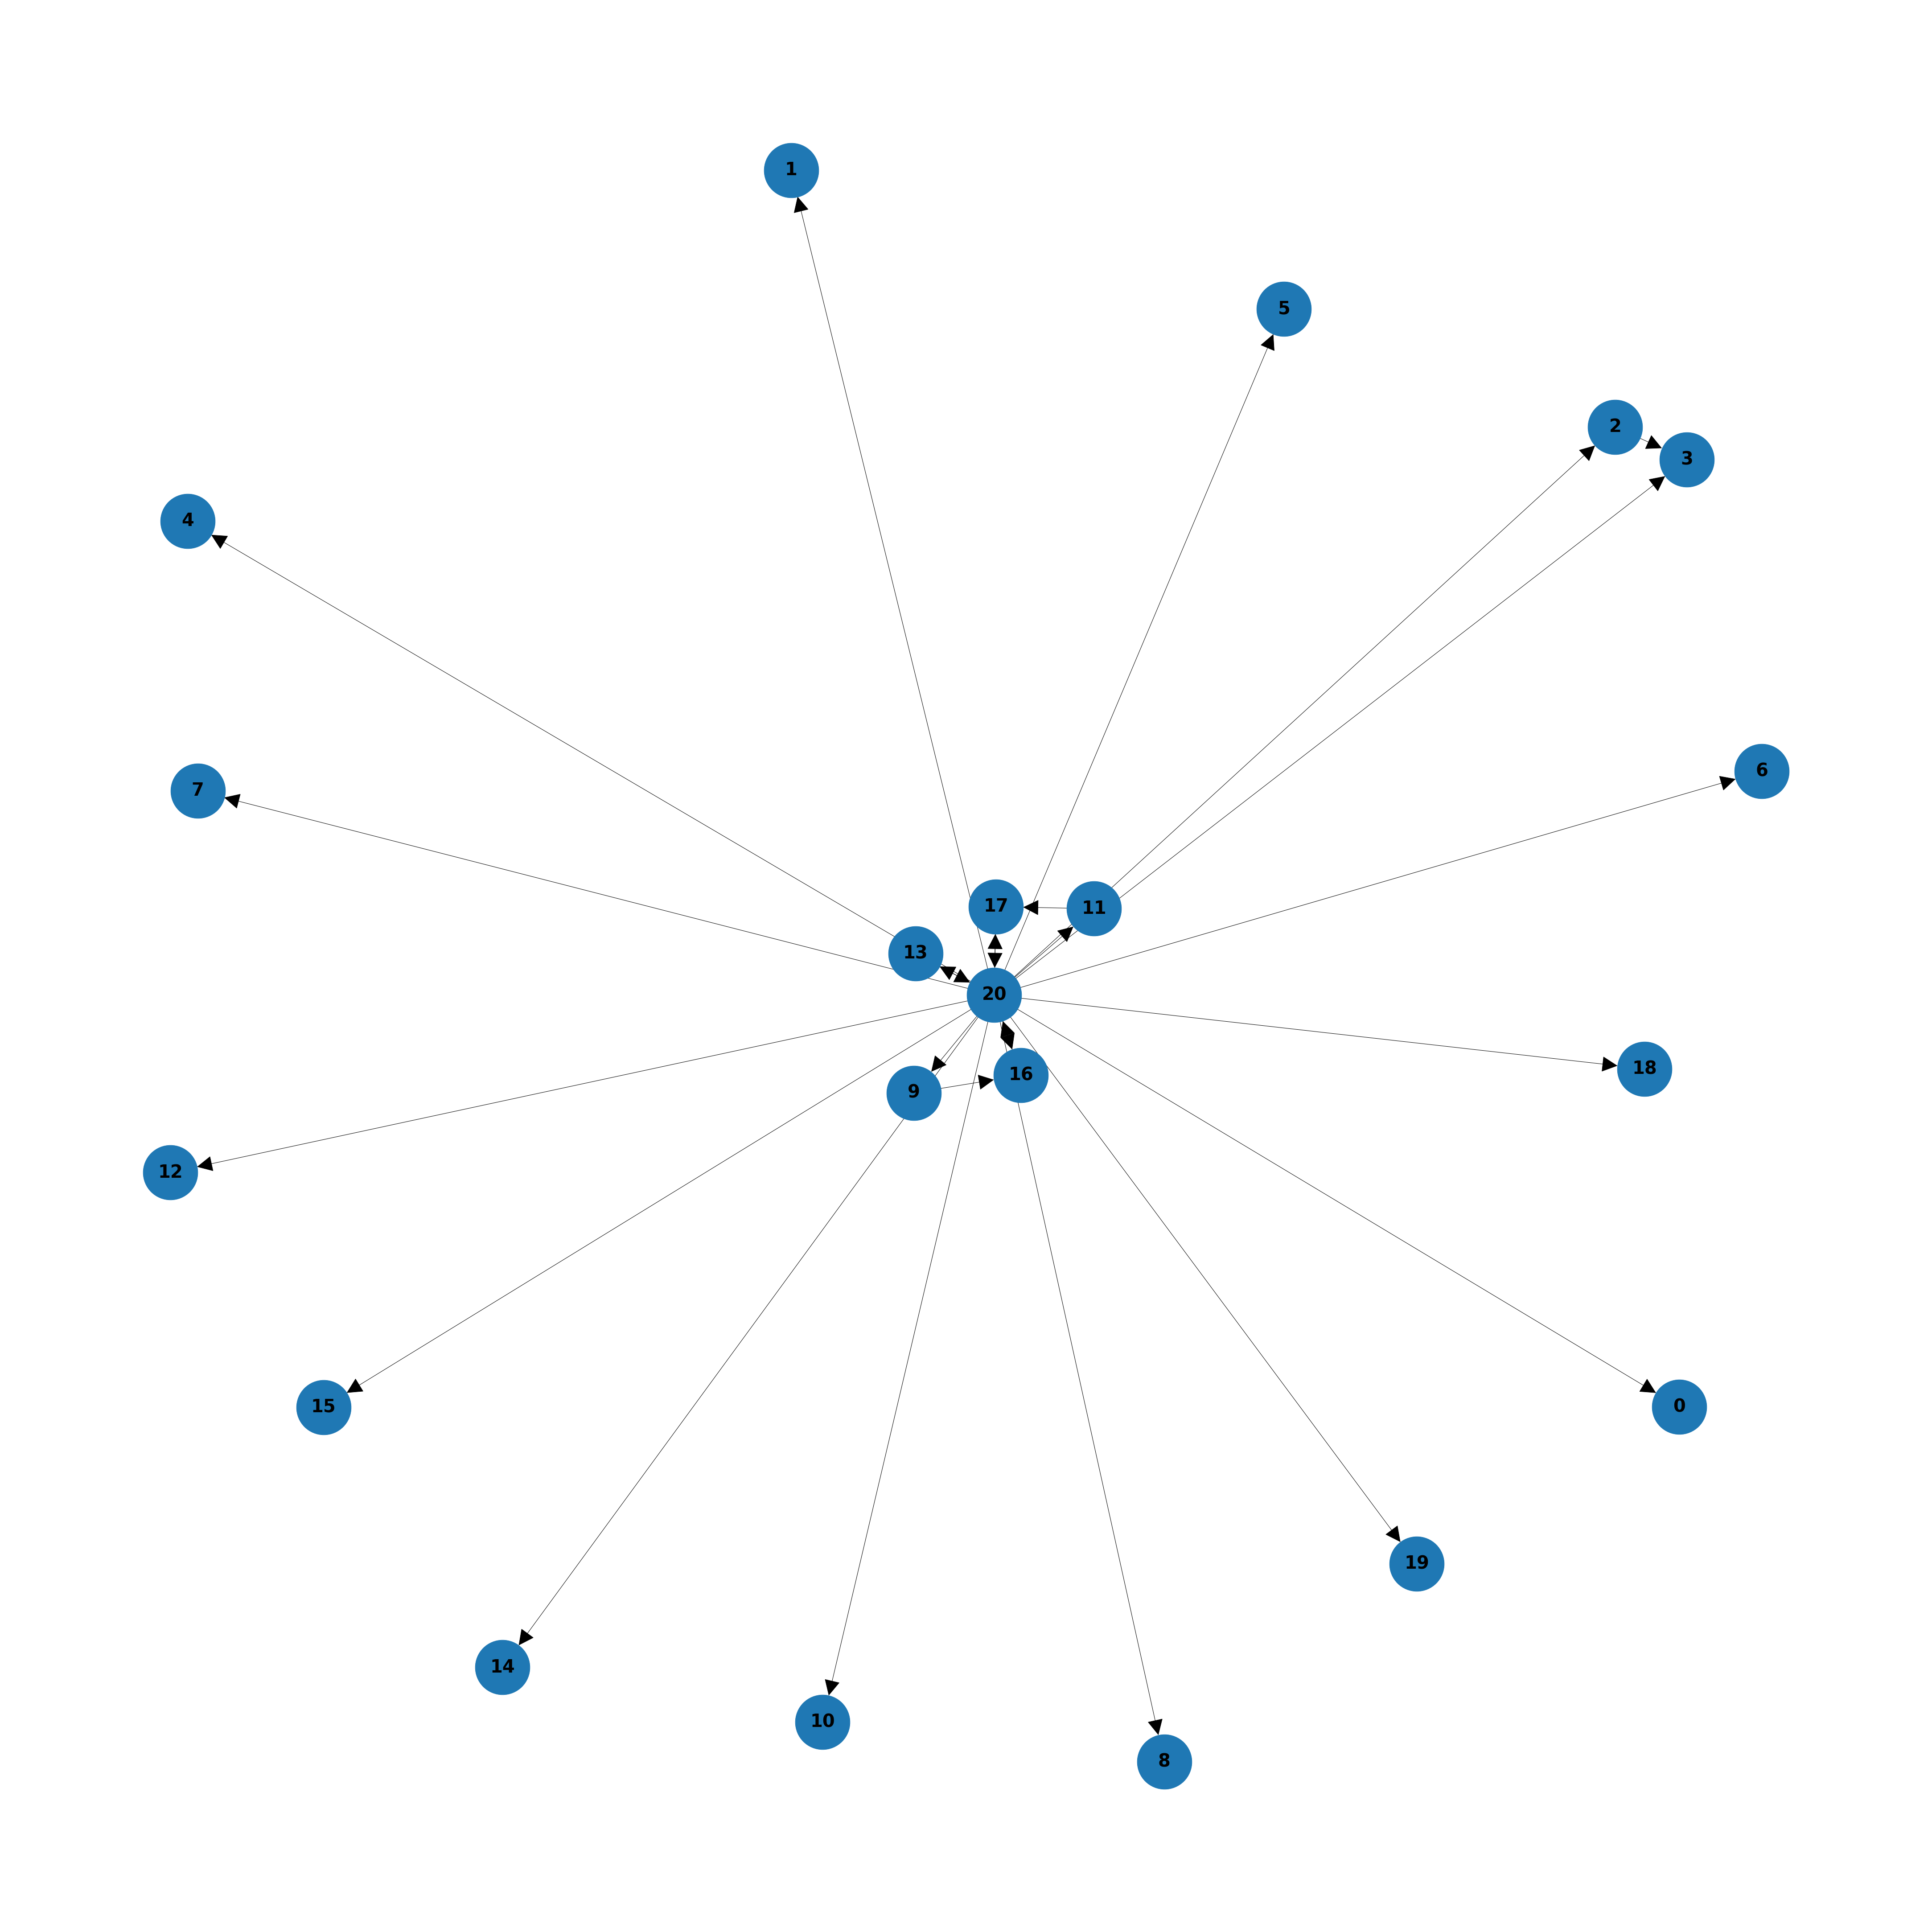

In [7]:
nx.draw_spring(G, 
        with_labels = True,
        node_size   = 15000,
        font_size   = 40,
        font_weight = "bold",
        arrowsize   = 80
       )

In [8]:
sorted(G.nodes(data=True))

[(0, {}),
 (1, {}),
 (2, {}),
 (3, {}),
 (4, {}),
 (5, {}),
 (6, {}),
 (7, {}),
 (8, {}),
 (9, {}),
 (10, {}),
 (11, {}),
 (12, {}),
 (13, {}),
 (14, {}),
 (15, {}),
 (16, {}),
 (17, {}),
 (18, {}),
 (19, {}),
 (20, {})]

[+] Edges_Labels.items(): dict_items([((6, 20), {'SMB'}), ((7, 20), {'SMB'}), ((8, 20), {'SMB'}), ((10, 20), {'SMB'}), ((12, 20), {'SMB'}), ((13, 20), {'SMB'}), ((14, 20), {'SMB'}), ((15, 20), {'SMB'}), ((17, 20), {'VPN', 'SMB'}), ((0, 5), {'RDP'}), ((5, 1), {'RDP'}), ((9, 20), {'RDP'}), ((12, 8), {'RDP'}), ((14, 6), {'RDP'}), ((20, 5), {'RDP'}), ((20, 16), {'RDP'}), ((0, 20), {'VPN'})])
[+] Printing u: 6, v: 20, port: {'SMB'}
[+] Printing u: 7, v: 20, port: {'SMB'}
[+] Printing u: 8, v: 20, port: {'SMB'}
[+] Printing u: 10, v: 20, port: {'SMB'}
[+] Printing u: 12, v: 20, port: {'SMB'}
[+] Printing u: 13, v: 20, port: {'SMB'}
[+] Printing u: 14, v: 20, port: {'SMB'}
[+] Printing u: 15, v: 20, port: {'SMB'}
[+] Printing u: 17, v: 20, port: {'VPN', 'SMB'}
[+] Printing u: 0, v: 5, port: {'RDP'}
[+] Printing u: 5, v: 1, port: {'RDP'}
[+] Printing u: 9, v: 20, port: {'RDP'}
[+] Printing u: 12, v: 8, port: {'RDP'}
[+] Printing u: 14, v: 6, port: {'RDP'}
[+] Printing u: 20, v: 5, port: {'RDP'

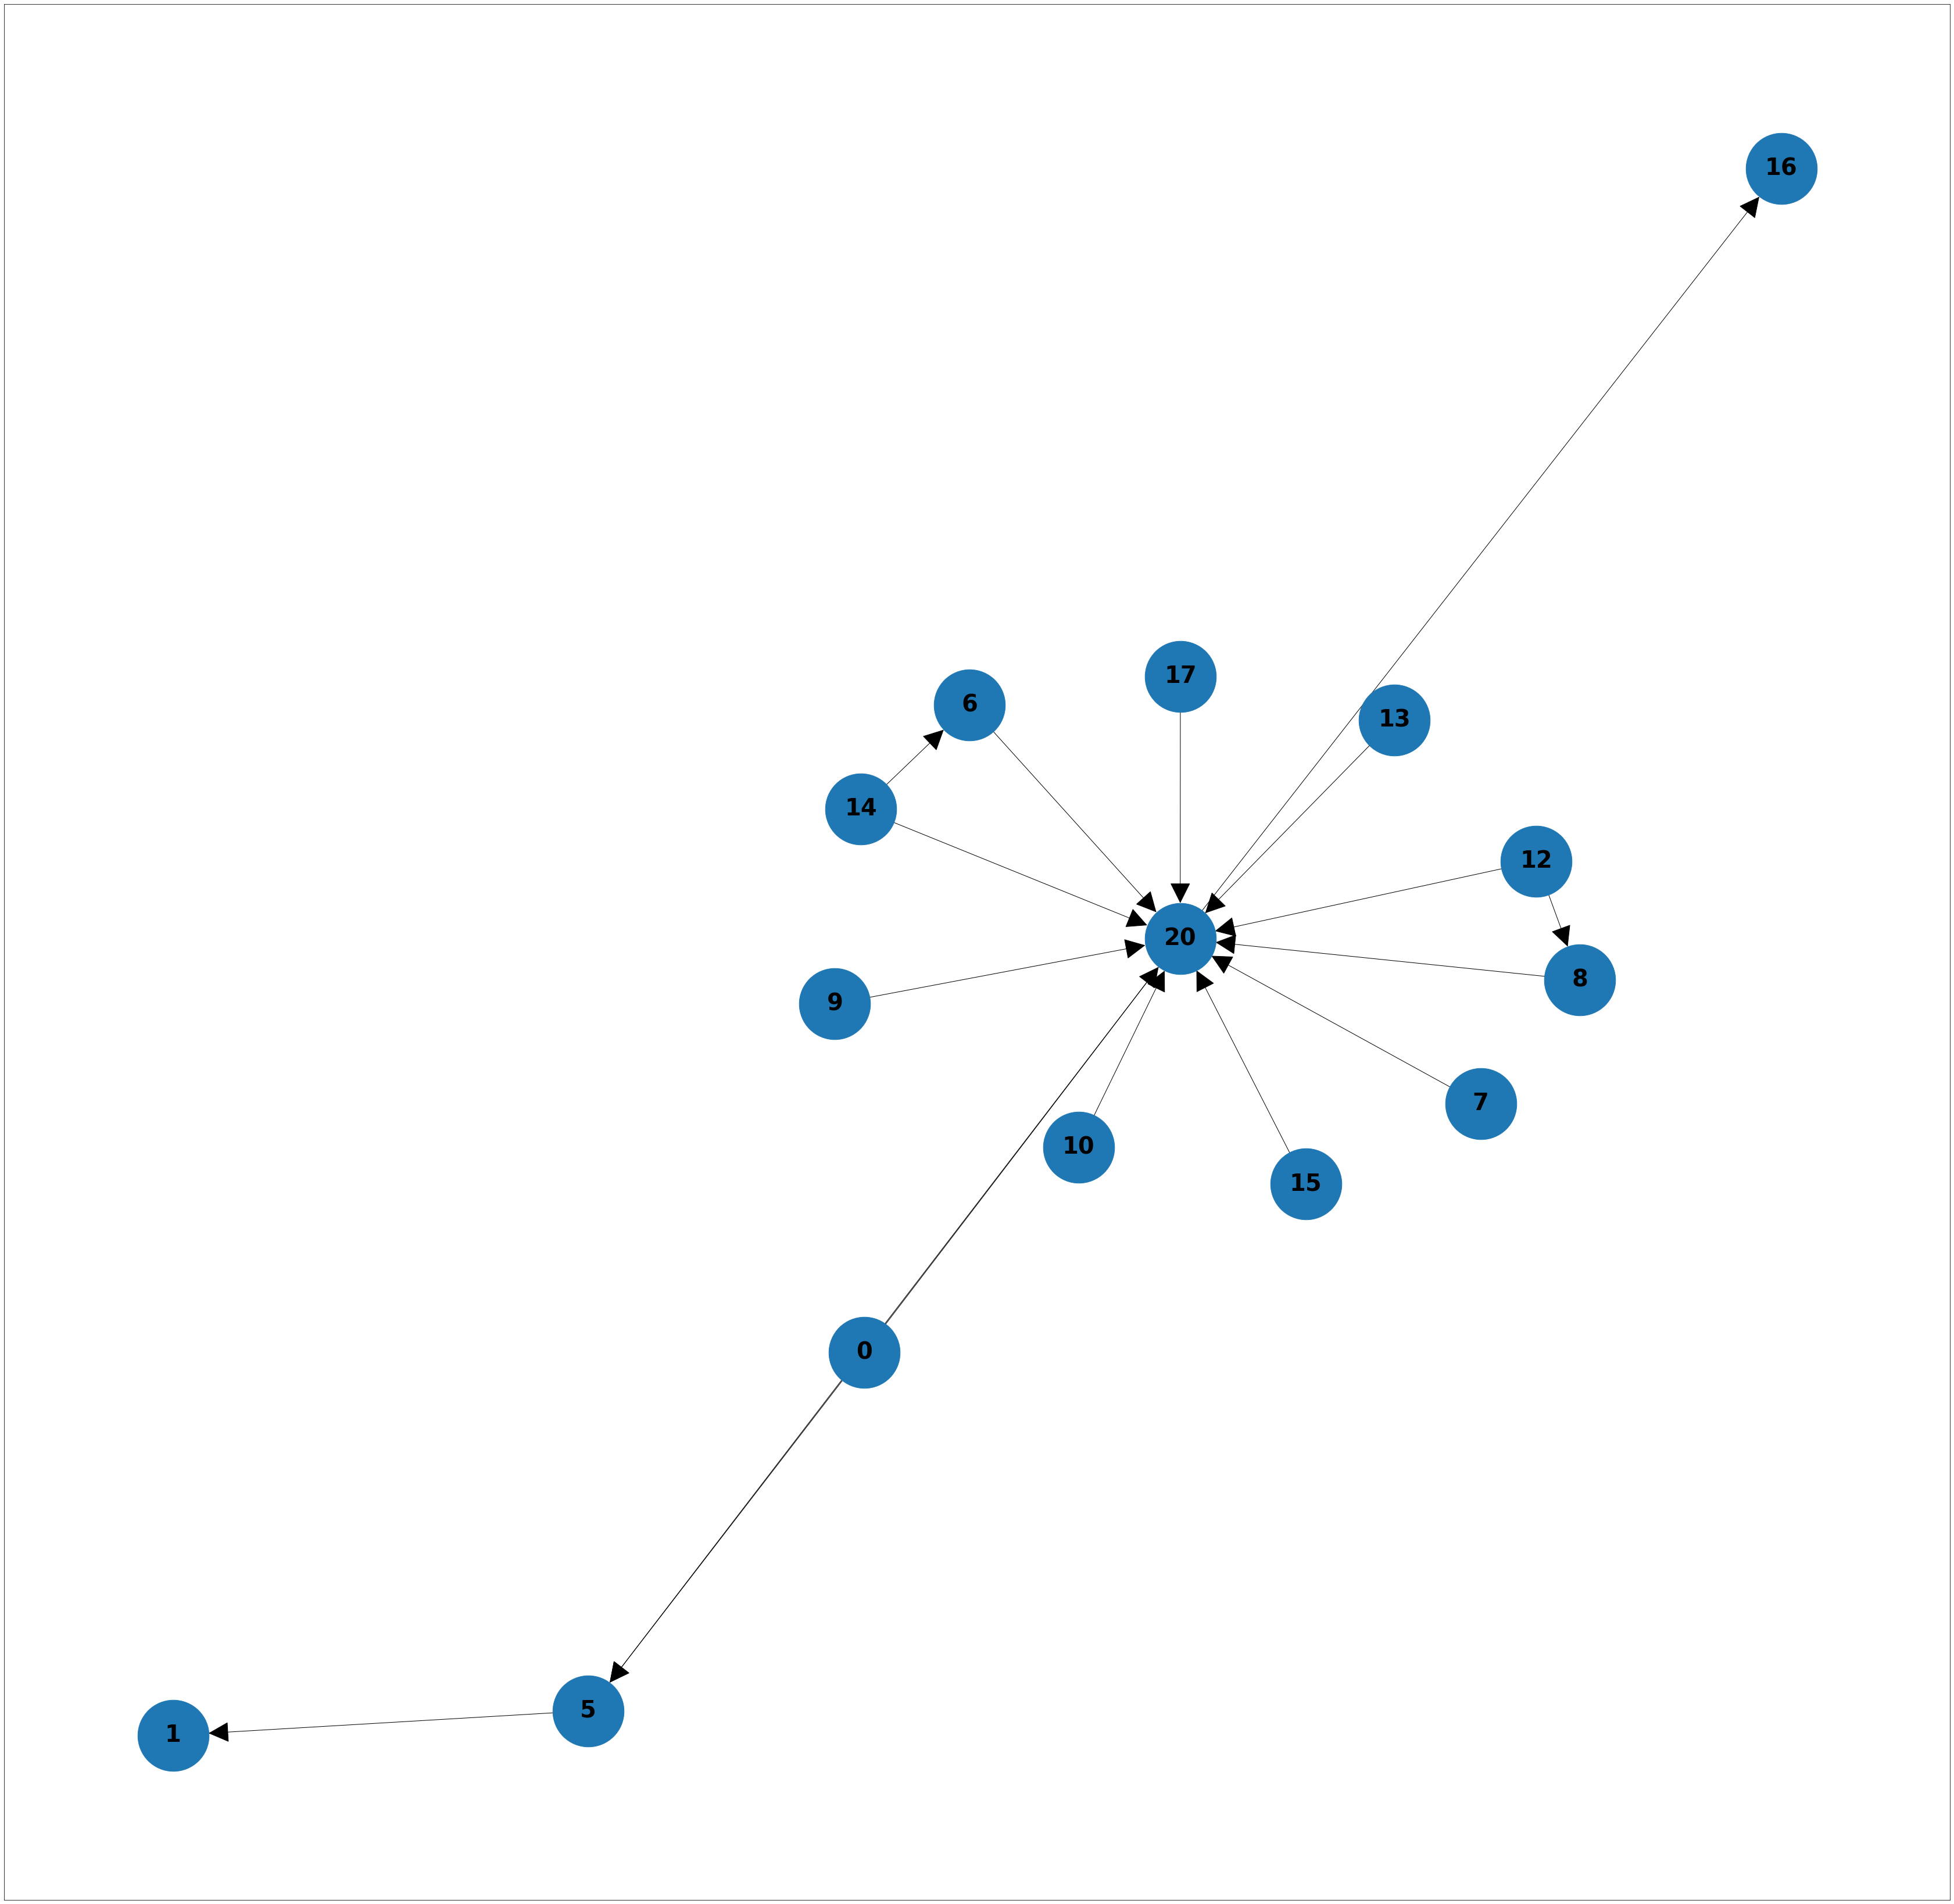

In [9]:
m = new_environment(1)

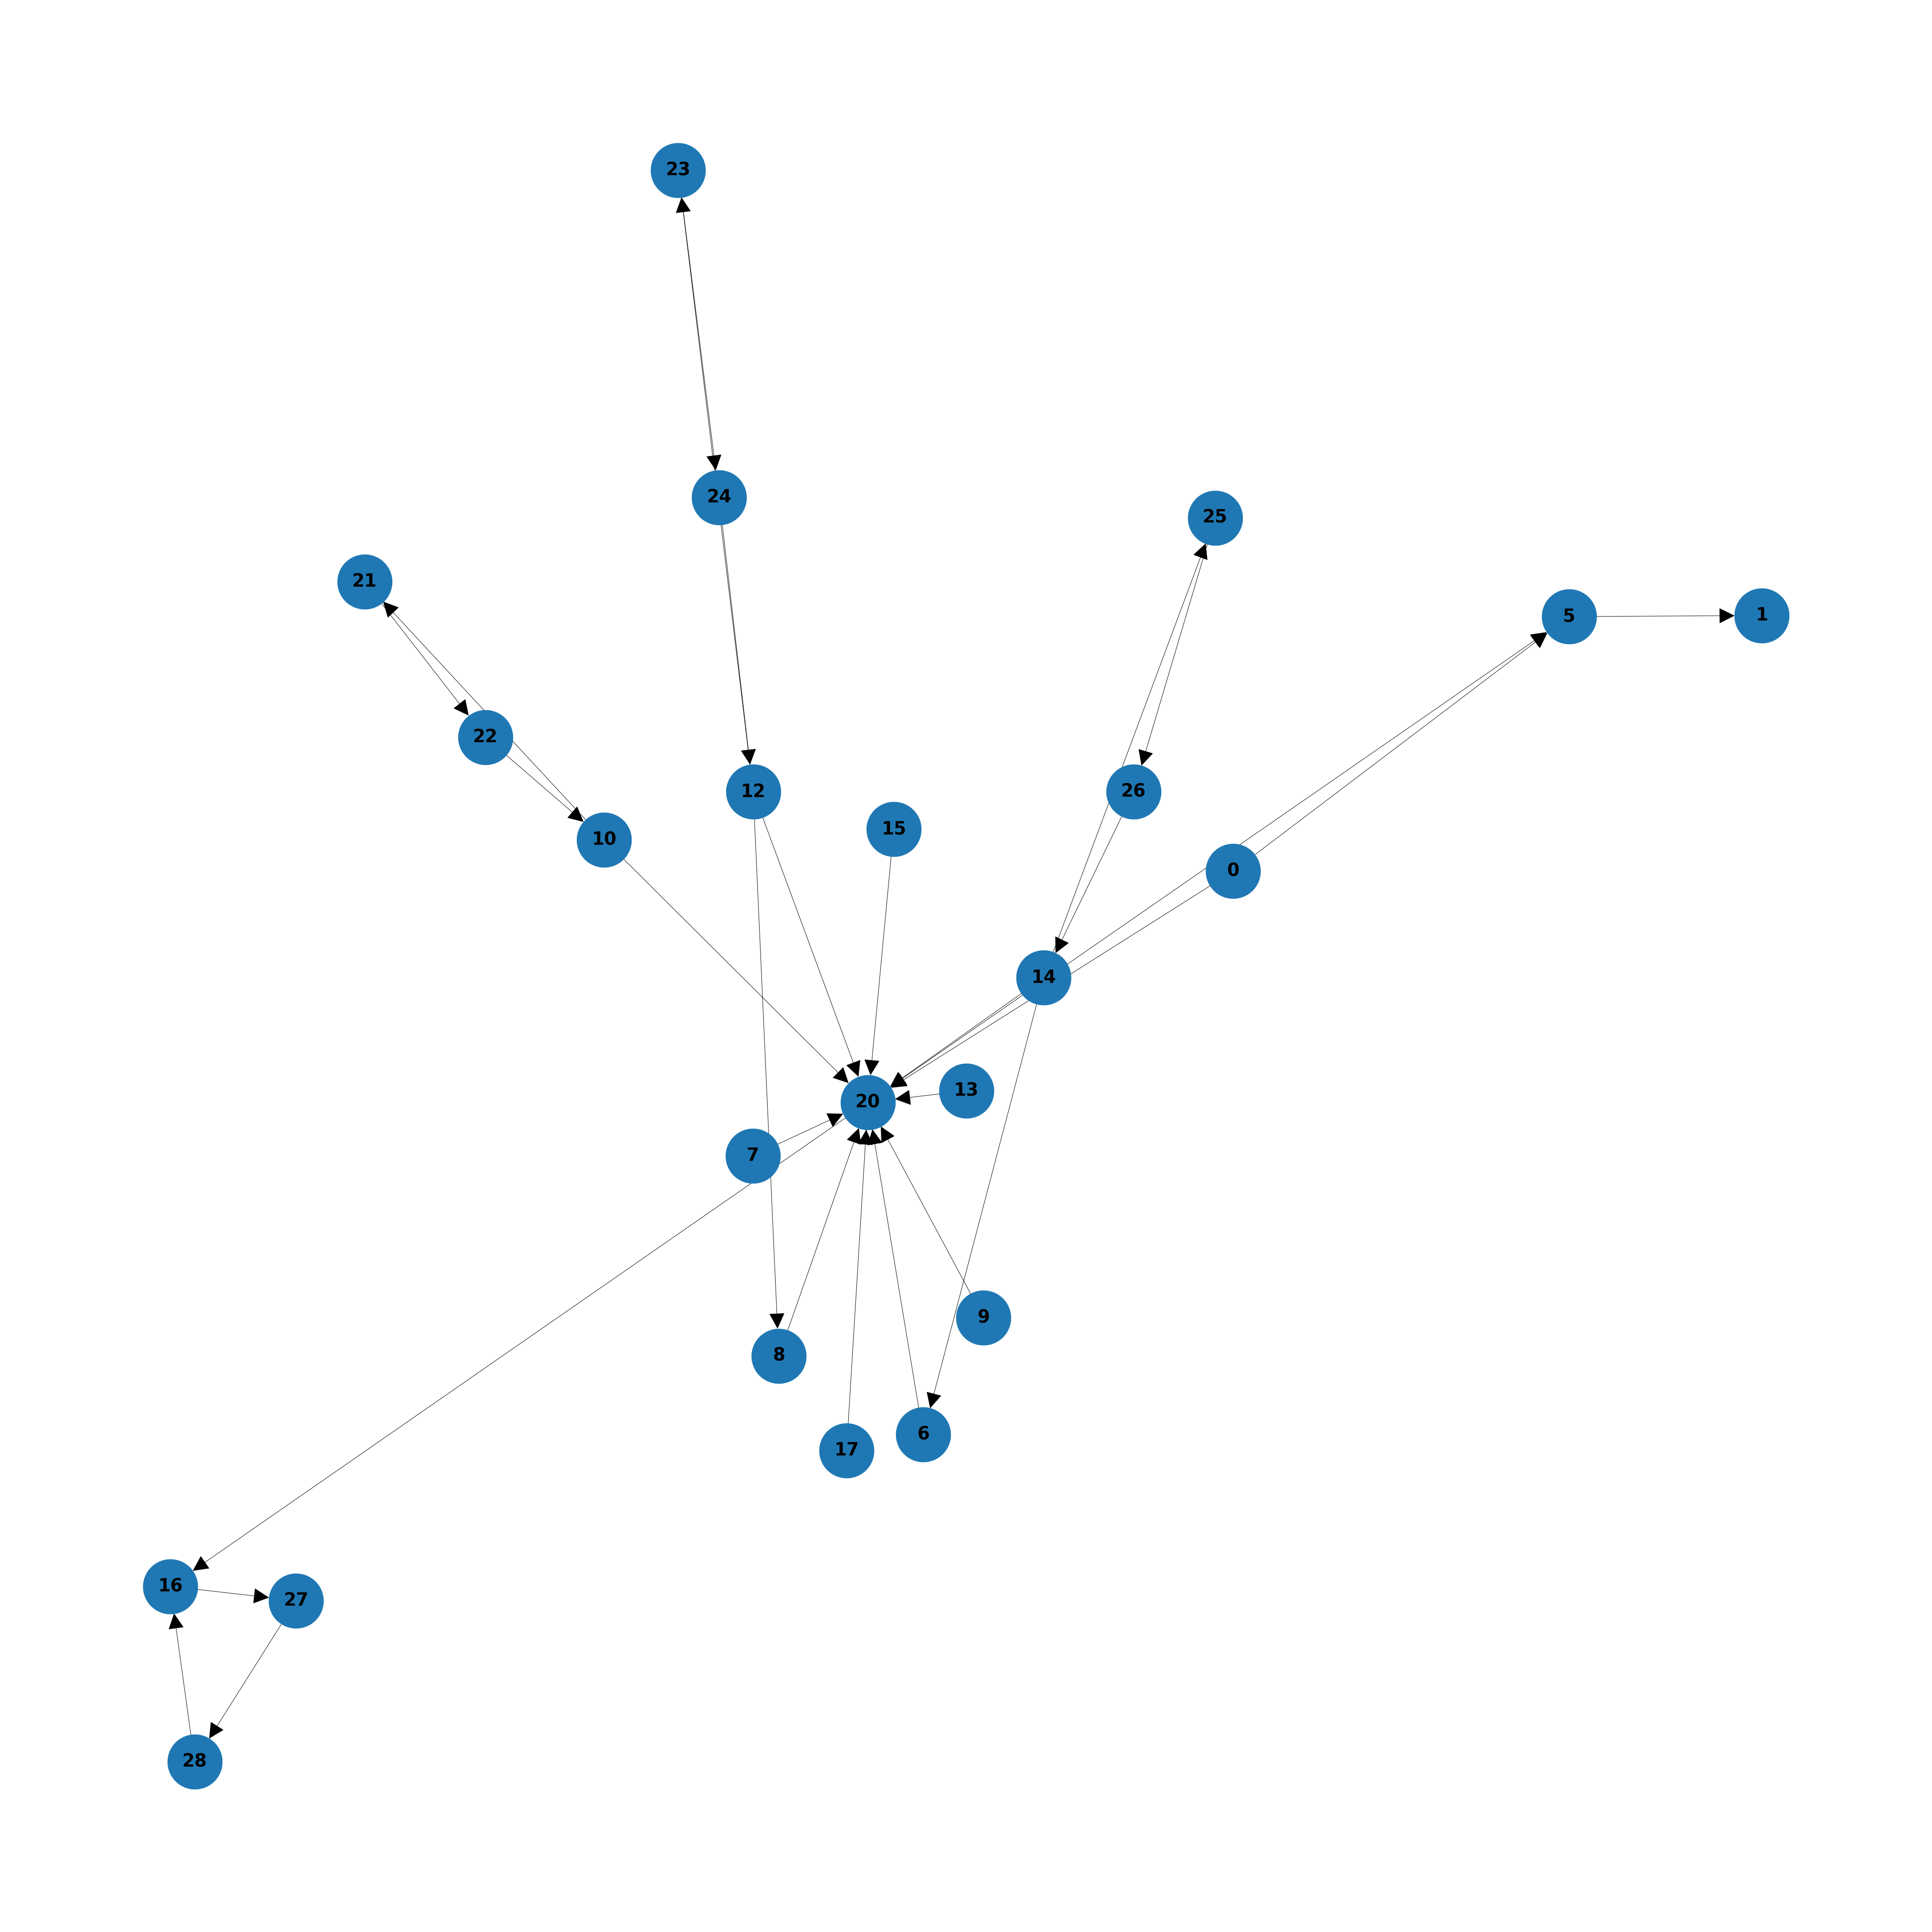

In [10]:
nx.draw_spring(m.network, 
        with_labels = True,
        node_size   = 15000,
        font_size   = 40,
        font_weight = "bold",
        arrowsize   = 80,
        
       )

In [11]:
m.network.nodes(data=True)

NodeDataView({'6': {'data': NodeInfo(services=[], vulnerabilities={'ScanWindowsExplorerRecentFiles': VulnerabilityInfo(description='Look for network shares in the Windows Explorer Recent files', type=<VulnerabilityType.LOCAL: 1>, outcome=<cyberbattle.simulation.model.LeakedNodesId object at 0x7fd79397e790>, precondition=<cyberbattle.simulation.model.Precondition object at 0x7fd799a7b9d0>, rates=Rates(probingDetectionRate=0.0, exploitDetectionRate=0.0, successRate=1.0), URL='', cost=1.0, reward_string='Windows Explorer Recent Files revealed network shares'), 'ScanWindowsCredentialManagerForSMB': VulnerabilityInfo(description='Look for network credentials in the Windows Credential Manager', type=<VulnerabilityType.LOCAL: 1>, outcome=<cyberbattle.simulation.model.LeakedCredentials object at 0x7fd793972fa0>, precondition=<cyberbattle.simulation.model.Precondition object at 0x7fd799a7b9d0>, rates=Rates(probingDetectionRate=0.0, exploitDetectionRate=0.0, successRate=1.0), URL='', cost=2.0, r

In [12]:
m.network.has_node('21')

True

In [17]:
m.get_node('21')

NodeInfo(services=[], vulnerabilities={'BadUSB': VulnerabilityInfo(description='Attempt to deploy a BadUSB Attack', type=<VulnerabilityType.REMOTE: 2>, outcome=<cyberbattle.simulation.model.LeakedNodesId object at 0x7fd7939878b0>, precondition=<cyberbattle.simulation.model.Precondition object at 0x7fd799a7b9d0>, rates=Rates(probingDetectionRate=0.0, exploitDetectionRate=0.0, successRate=1.0), URL='', cost=5.0, reward_string='Discovered new network nodes via BadUSB')}, value=28, properties=[], firewall=None, agent_installed=False, privilege_level=<PrivilegeLevel.NoAccess: 0>, reimagable=True, last_reimaging=None, owned_string='', sla_weight=1.0)

In [18]:
m.get_node('22')

NodeInfo(services=[], vulnerabilities={'VPN_Tunnel': VulnerabilityInfo(description='Attempt to Connect to Remote Machine VIA VPN', type=<VulnerabilityType.REMOTE: 2>, outcome=<cyberbattle.simulation.model.LeakedNodesId object at 0x7fd7939879a0>, precondition=<cyberbattle.simulation.model.Precondition object at 0x7fd799a7b9d0>, rates=Rates(probingDetectionRate=0.0, exploitDetectionRate=0.0, successRate=1.0), URL='', cost=5.0, reward_string='Discovered new network nodes via VPN Tunneling')}, value=59, properties=[], firewall=FirewallConfiguration(outgoing=[FirewallRule(port='RDP', permission=<RulePermission.ALLOW: 0>, reason=''), FirewallRule(port='SMB', permission=<RulePermission.ALLOW: 0>, reason=''), FirewallRule(port='VPN', permission=<RulePermission.ALLOW: 0>, reason='')], incoming=[FirewallRule(port='RDP', permission=<RulePermission.ALLOW: 0>, reason=''), FirewallRule(port='SMB', permission=<RulePermission.ALLOW: 0>, reason=''), FirewallRule(port='VPN', permission=<RulePermission.A

In [19]:
sorted(list(m.network.nodes))

['0',
 '1',
 '10',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '5',
 '6',
 '7',
 '8',
 '9']

In [20]:
m.nodes

<bound method Environment.nodes of Environment(network=<networkx.classes.digraph.DiGraph object at 0x7fd7939723a0>, vulnerability_library={}, identifiers=Identifiers(properties=['breach_node'], ports=['SMB', 'HTTP', 'RDP', 'VPN'], local_vulnerabilities=['ScanWindowsCredentialManagerForRDP', 'ScanWindowsExplorerRecentFiles', 'ScanWindowsCredentialManagerForSMB'], remote_vulnerabilities=['Traceroute', 'ConnectToMachineViaVPN'], physical_vulnerabilities=['BadUSB']), creationTime=datetime.datetime(2022, 2, 8, 14, 23, 16, 35774), lastModified=datetime.datetime(2022, 2, 8, 14, 23, 16, 35775), version='0.1.0')>

In [21]:
# ! Running = True !

m.get_node('5')


NodeInfo(services=[ListeningService(name='RDP', allowedCredentials=['unique_pwd2'], running=True)], vulnerabilities={'ScanWindowsExplorerRecentFiles': VulnerabilityInfo(description='Look for network shares in the Windows Explorer Recent files', type=<VulnerabilityType.LOCAL: 1>, outcome=<cyberbattle.simulation.model.LeakedNodesId object at 0x7fd79397e790>, precondition=<cyberbattle.simulation.model.Precondition object at 0x7fd799a7b9d0>, rates=Rates(probingDetectionRate=0.0, exploitDetectionRate=0.0, successRate=1.0), URL='', cost=1.0, reward_string='Windows Explorer Recent Files revealed network shares'), 'ScanWindowsCredentialManagerForSMB': VulnerabilityInfo(description='Look for network credentials in the Windows Credential Manager', type=<VulnerabilityType.LOCAL: 1>, outcome=<cyberbattle.simulation.model.LeakedCredentials object at 0x7fd793972fa0>, precondition=<cyberbattle.simulation.model.Precondition object at 0x7fd799a7b9d0>, rates=Rates(probingDetectionRate=0.0, exploitDetect

In [20]:
# And here
m.get_node('5').status

<MachineStatus.Running: 1>

In [16]:
node_attributes = dir(m.get_node('3'))

In [17]:
node_attributes

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'agent_installed',
 'firewall',
 'last_reimaging',
 'owned_string',
 'privilege_level',
 'properties',
 'reimagable',
 'services',
 'sla_weight',
 'status',
 'value',
 'vulnerabilities']